In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats 

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset

# imports from captum library
from captum.attr import GradientShap, IntegratedGradients, NoiseTunnel, DeepLift

from nn_brain_age_prediction import grid_search, BrainAgeModel, train
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [57]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,scipy,torch,captum,scikit-learn -g 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.1
IPython version      : 8.24.0

numpy       : 1.26.4
pandas      : 2.2.2
matplotlib  : 3.8.4
scipy       : 1.13.0
torch       : 2.3.0
captum      : 0.7.0
scikit-learn: 1.4.2

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 1bd66f979bc0ae7d1d751076fe18c43146dad1a0



In [58]:
BD_synthetic = pd.read_csv('../data/BD_synthetic.csv', index_col=False)
HC_synthetic = pd.read_csv('../data/HC_synthetic.csv', index_col=False)

In [59]:
# helper functions
def selectFeatures(df, feature_names):
    contains_columns = df.columns.str.contains(feature_names)
    subset_df = df.iloc[:, contains_columns]
    return subset_df

In [60]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal|Age' # select features that are correlated with BD vs. HC differences found in previous studies
HC_synthetic = selectFeatures(HC_synthetic, pattern) 

In [61]:
X = HC_synthetic.drop(columns=['Age at Visit']).values  
y = HC_synthetic['Age at Visit'].values 

In [62]:
normalized_X = X- np.min(X)/np.max(X) - np.min(X) # MinMax normalization

In [63]:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.3, random_state=0) # create test and train sets

In [64]:
tstat, p_val = stats.ttest_ind(y_train, y_test) # ensure that the distribution of ages between the train and test sets are similar by doing a t-test
print(tstat, p_val)

0.2909600643133595 0.7715926562226898


### Tensorize the datasets

In [65]:
X_train = torch.tensor(X_train).float() # convert arrays to tensors
y_train = torch.tensor(y_train).view(-1, 1).float() 

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

### Create a Python class to represent the Brain Age Model

In [114]:

# Define the grid of hyperparameters
param_grid = {
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'size_hidden1': [50, 75, 100],
    'size_hidden2': [25, 50, 75],
    'size_hidden3': [10, 20],
    'size_hidden4': [1],  # Output size fixed to 1
    'num_epochs': [10, 20]  
}

train_data =  TensorDataset(X_train[:60], y_train[:60])
val_data = TensorDataset(X_train[60:], y_train[60:])
n_feautres = X_train.shape[1]
best_params, best_score = grid_search(n_feautres,  param_grid, train_data, val_data)

[(32, 0.001, 50, 25, 10, 1, 10), (32, 0.001, 50, 25, 10, 1, 20), (32, 0.001, 50, 25, 20, 1, 10), (32, 0.001, 50, 25, 20, 1, 20), (32, 0.001, 50, 50, 10, 1, 10), (32, 0.001, 50, 50, 10, 1, 20), (32, 0.001, 50, 50, 20, 1, 10), (32, 0.001, 50, 50, 20, 1, 20), (32, 0.001, 50, 75, 10, 1, 10), (32, 0.001, 50, 75, 10, 1, 20), (32, 0.001, 50, 75, 20, 1, 10), (32, 0.001, 50, 75, 20, 1, 20), (32, 0.001, 75, 25, 10, 1, 10), (32, 0.001, 75, 25, 10, 1, 20), (32, 0.001, 75, 25, 20, 1, 10), (32, 0.001, 75, 25, 20, 1, 20), (32, 0.001, 75, 50, 10, 1, 10), (32, 0.001, 75, 50, 10, 1, 20), (32, 0.001, 75, 50, 20, 1, 10), (32, 0.001, 75, 50, 20, 1, 20), (32, 0.001, 75, 75, 10, 1, 10), (32, 0.001, 75, 75, 10, 1, 20), (32, 0.001, 75, 75, 20, 1, 10), (32, 0.001, 75, 75, 20, 1, 20), (32, 0.001, 100, 25, 10, 1, 10), (32, 0.001, 100, 25, 10, 1, 20), (32, 0.001, 100, 25, 20, 1, 10), (32, 0.001, 100, 25, 20, 1, 20), (32, 0.001, 100, 50, 10, 1, 10), (32, 0.001, 100, 50, 10, 1, 20), (32, 0.001, 100, 50, 20, 1, 10), 

In [68]:
datasets = TensorDataset(X_train, y_train)
train_iter = DataLoader(datasets, best_params['batch_size'], shuffle=True)

print('batch_size:', best_params['batch_size'],  
      '\nnum_epoch:', best_params['num_epochs'],
     '\nlearning_rate:',best_params['learning_rate'], 
      '\nsize_hidden1:', best_params['size_hidden1'], 
      '\nsize_hidden2:',best_params['size_hidden2'], 
      '\nsize_hidden3:',best_params['size_hidden3'])

batch_size: 32 
num_epoch: 20 
learning_rate: 0.001 
size_hidden1: 100 
size_hidden2: 50 
size_hidden3: 10


In [69]:

datasets = TensorDataset(X_train, y_train)
train_iter = DataLoader(datasets, best_params['batch_size'], shuffle=True)

In [70]:
criterion = nn.MSELoss(reduction='sum')

In [71]:
model = BrainAgeModel(input_size=9,
                      size_hidden1=best_params['size_hidden1'],
                      size_hidden2=best_params['size_hidden2'],
                      size_hidden3=best_params['size_hidden3'],
                      size_hidden4=best_params['size_hidden4'])

train_data_combined = train_data + val_data  # Assuming you combine training and validation datasets for final training
train(model, best_params['num_epochs'], criterion, best_params['learning_rate'], train_iter)


Epoch [1]/[20] running accumulative loss across all batches: 1099555.997


### Test model on data from healthy individuals 

In [72]:
model.eval()
y_pred = model(X_test)
mse = (mean_squared_error(y_pred.detach().numpy(), y_test.detach().numpy()))
print('model err: ', round(mse, 2))

model err:  185.89


In [73]:
mae = mean_absolute_error(y_pred.detach().numpy(), y_test.detach().numpy())
print('model err: ', round(mae, 2))

model err:  11.06


In [74]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)


/home/nghuixin/.pyenv/versions/3.11.1/envs/TSciM/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/nghuixin/.pyenv/versions/3.11.1/envs/TSciM/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [75]:
feature_names = HC_synthetic.iloc[:, 1:].columns

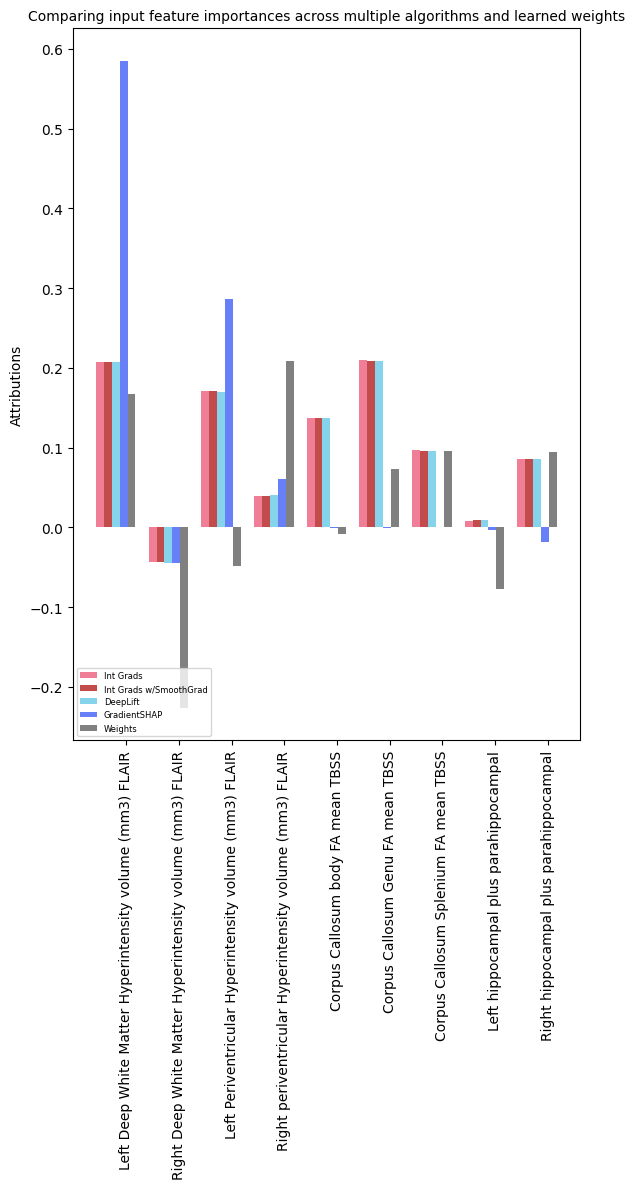

In [94]:

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']


x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

plt.figure(figsize=(6, 12))
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 10
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

width = 0.15  # Assuming this variable setup exists

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)  # Adjust as per your code structure
ax.set_xticklabels(x_axis_data_labels, rotation=90)  # Rotation added here
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP',  'Weights']

plt.legend(legends, loc=3)
plt.tight_layout()  # Ensures everything fits without overlap
plt.show()


### Brain-PAD of Individuals with BD

In [80]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal|Age'
BD_X = selectFeatures(BD_synthetic, pattern)
BD_X = BD_X.drop(columns= ['Age at Visit']).values
BD_y = BD_synthetic['Age at Visit'].values

In [81]:
normalized_BD_X = BD_X - np.min(BD_X)/(np.max(BD_X)- np.min(BD_X))

In [82]:
normalized_BD_X = torch.tensor(normalized_BD_X).float()
BD_y = torch.tensor(BD_y).view(-1, 1).float()

In [113]:
model.eval()
BD_y_pred = model(normalized_BD_X)


###  Brain-PADs across BD and HC individuals

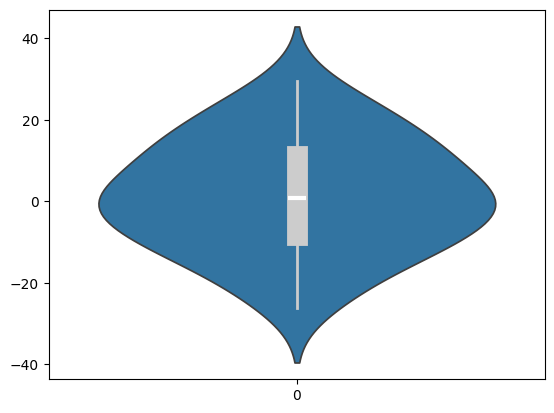

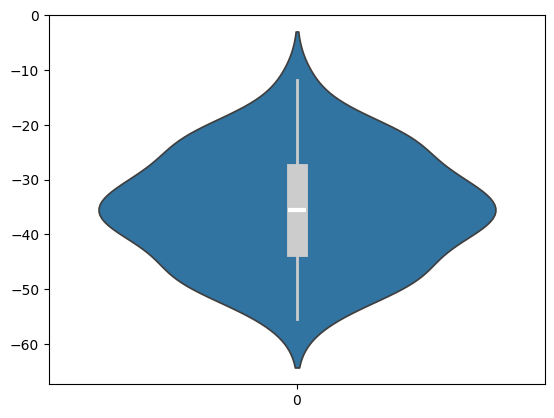

In [111]:
bpad_hc = (y_pred.detach().numpy()- y_test.detach().numpy())
bpad_bd = (BD_y_pred.detach().numpy()- BD_y.detach().numpy())
sns.violinplot(bpad_hc,  inner_kws=dict(box_width=15, whis_width=2, color=".8"))
plt.show()

sns.violinplot(bpad_bd,  inner_kws=dict(box_width=15, whis_width=2, color=".8"))
plt.show()
